In [8]:
#Librarires and functions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import Video

from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.arena import FlatTerrain
from flygym.mujoco.arena.tethered import Tethered
from flygym.mujoco.examples.common import PreprogrammedSteps
from flygym.mujoco.examples.cpg_controller import CPGNetwork

from gymnasium import spaces
from gymnasium.utils.env_checker import check_env
import cv2

In [2]:
#Implementing a standard tripod gait
_tripod_phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
_tripod_coupling_weights = (_tripod_phase_biases > 0) * 10

In [3]:
#Implementing a windy arena with a laminar wind
from dm_control.mjcf.physics import Physics


class WindArena(FlatTerrain):
    def __init__(
        self,
        #Change wind direction here
        wind_vector=[ -1, 3, 0],
        medium_density=0.01,
        medium_viscosity=0.01,
        **kwargs
    ):
        super().__init__(**kwargs)
        self._add_wind(wind_vector, medium_density, medium_viscosity)

    def _add_wind(self, wind_vector, medium_density, medium_viscosity):
        # Here I directly change the fields of the xml option element
        self.root_element.option.__setattr__("density", medium_density)
        self.root_element.option.__setattr__("viscosity", medium_viscosity)
        self.root_element.option.__setattr__("wind", wind_vector)
    

wind_arena = WindArena()

In [28]:
from typing import Any, Dict, Tuple

class WindTurningNMF(NeuroMechFly):
    def __init__(
        self,
        preprogrammed_steps=None,
        intrinsic_freqs=np.ones(6) * 12,
        intrinsic_amps=np.ones(6) * 1,
        phase_biases=_tripod_phase_biases,
        coupling_weights=_tripod_coupling_weights,
        convergence_coefs=np.ones(6) * 20,
        init_phases=None,
        init_magnitudes=None,
        amplitude_range=(-0.5, 1.5),
        seed=0,
        **kwargs,
    ):
        # Initialize core NMF simulation
        super().__init__(**kwargs)

        if preprogrammed_steps is None:
            preprogrammed_steps = PreprogrammedSteps()
        self.preprogrammed_steps = preprogrammed_steps
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.phase_biases = phase_biases
        self.coupling_weights = coupling_weights
        self.convergence_coefs = convergence_coefs
        self.amplitude_range = amplitude_range

        # Define action and observation spaces
        self.action_space = spaces.Box(*amplitude_range, shape=(2,))

        # Initialize CPG network
        self.cpg_network = CPGNetwork(
            timestep=self.sim_params.timestep,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=seed,
        )
        self.cpg_network.reset(init_phases, init_magnitudes)
    
    def _set_joints_stiffness_and_damping(self):
        for joint in self.model.find_all("joint"):
            if joint.name in self.actuated_joints:
                joint.stiffness = self.sim_params.joint_stiffness
                joint.damping = self.sim_params.joint_damping
            #elif "Arista" in joint.name:
                #joint.stiffness = 0.002
                #joint.damping = 1e-5
            elif "LArista" in joint.name:
                joint.stiffness = 0.006
                joint.damping = 2e-4
            elif "RArista" in joint.name:
                joint.stiffness = 0.006
                joint.damping = 2e-4
            elif "Head" in joint.name:
                joint.stiffness = 1000.0
                joint.damping = 1000.0
            else:
                joint.stiffness = self.sim_params.non_actuated_joint_stiffness
                joint.damping = self.sim_params.non_actuated_joint_damping
            
    def _add_joint_sensors(self):
        self._arista_sensors = []
        self._debug_end_effectors = []

        for side in "LR":
            arista_sensor_joint = self.model.sensor.add(
                "jointpos", name=f"jointpos_{side}Arista", joint=f"joint_{side}Arista"
            )
            arista_sensor_torque = self.model.sensor.add(
                "jointactuatorfrc", name=f"jointactuatorfrc_{side}Arista", joint=f"joint_{side}Arista"
            )
            self._arista_sensors.append(arista_sensor_torque)
            self._arista_sensors.append(arista_sensor_joint)            

        return super()._add_joint_sensors()
    
    def get_observation(self):
        obs = super().get_observation()
        arista_obs = self.physics.bind(self._arista_sensors).sensordata
        body_pos = self.physics.bind(self._body_sensors).sensordata
        obs["arista_joint_pos"] = arista_obs.copy()
        obs["body_pos"] = body_pos.copy()
        
        return obs
    
    def _define_observation_space(self):
        _observation_space = {
            "joints": spaces.Box(
                low=-np.inf, high=np.inf, shape=(3, len(self.actuated_joints))
            ),
            "fly": spaces.Box(low=-np.inf, high=np.inf, shape=(4, 3)),
            "contact_forces": spaces.Box(
                low=-np.inf, high=np.inf, shape=(len(self.contact_sensor_placements), 3)
            ),
            # x, y, z positions of the end effectors (tarsus-5 segments)
            "end_effectors": spaces.Box(low=-np.inf, high=np.inf, shape=(6, 3)),
            "fly_orientation": spaces.Box(low=-np.inf, high=np.inf, shape=(3,)),
            "arista_joint_pos": spaces.Box(low=-np.inf, high=np.inf, shape=(4,))
        }
        if self.sim_params.enable_vision:
            _observation_space["vision"] = spaces.Box(
                low=0,
                high=255,
                shape=(2, self._mujoco_config["vision"]["num_ommatidia_per_eye"], 2),
            )
        if self.sim_params.enable_olfaction:
            _observation_space["odor_intensity"] = spaces.Box(
                low=0,
                high=np.inf,
                shape=(self.arena.odor_dimensions, len(self._antennae_sensors)),
            )
        return spaces.Dict(_observation_space)

    def reset(self, seed=None, init_phases=None, init_magnitudes=None, **kwargs):
        obs, info = super().reset(seed=seed)
        self.cpg_network.random_state = np.random.RandomState(seed)
        self.cpg_network.intrinsic_amps = self.intrinsic_amps
        self.cpg_network.intrinsic_freqs = self.intrinsic_freqs
        self.cpg_network.reset(init_phases, init_magnitudes)
        #Reset the obs by hand
        obs["arista_joint_pos"] = np.zeros((4,))
        return obs, info

    def step(self, action):
        """Step the simulation forward one timestep.

        Parameters
        ----------
        action : np.ndarray
            Array of shape (2,) containing descending signal encoding
            turning.
        """
        # update CPG parameters
        amps = np.repeat(np.abs(action[:, np.newaxis]), 3, axis=1).flatten()
        freqs = self.intrinsic_freqs.copy()
        freqs[:3] *= 1 if action[0] > 0 else -1
        freqs[3:] *= 1 if action[1] > 0 else -1
        self.cpg_network.intrinsic_amps = amps
        self.cpg_network.intrinsic_freqs = freqs

        self.cpg_network.step()

        joints_angles = []
        adhesion_onoff = []
        for i, leg in enumerate(self.preprogrammed_steps.legs):
            # get target angles from CPGs and apply correction
            my_joints_angles = self.preprogrammed_steps.get_joint_angles(
                leg,
                self.cpg_network.curr_phases[i],
                self.cpg_network.curr_magnitudes[i],
            )
            joints_angles.append(my_joints_angles)

            # get adhesion on/off signal
            my_adhesion_onoff = self.preprogrammed_steps.get_adhesion_onoff(
                leg, self.cpg_network.curr_phases[i]
            )
            adhesion_onoff.append(my_adhesion_onoff)

        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        return super().step(action)

windturning_nmf = WindTurningNMF(Parameters())
windturning_nmf._arista_sensors

[MJCF Element: <jointactuatorfrc name="jointactuatorfrc_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointpos name="jointpos_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointactuatorfrc name="jointactuatorfrc_RArista" joint="joint_RArista"/>,
 MJCF Element: <jointpos name="jointpos_RArista" joint="joint_RArista"/>]

In [29]:
run_time = 5

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_top",


    #render_camera="Animat/camera_front_zoomin",
    render_playspeed=0.5,
    enable_adhesion=True
)

nmf = WindTurningNMF(
    sim_params = sim_params,
    arena = WindArena(),
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0,0,0.2)
)

#check_env(nmf)

In [30]:
obs_list = []
magnitude_hist = []
end_effector_L = []
end_effector_R = []

AverageWindowL = np.array([])
AverageWindowR = np.array([])

target_num_steps = int(run_time / nmf.timestep)

obs, info = nmf.reset(seed=0)

for i in trange(target_num_steps) :
    curr_time = i * nmf.sim_params.timestep #might be useless
    #if((L-R)>0.010):
    #  action=np.array([1, 0.2])
    #if((L-R)<-0.010):
    #  action=np.array([0.1, 1])

    L = obs["arista_joint_pos"][1]
    R = obs["arista_joint_pos"][3]

    if((L-R)>0.008) :
        action=np.array([1, 0.2])
    else :
        action = np.array([1, 1])
    
    obs, reward, terminated, truncated, info = nmf.step(action)

    AverageWindowL=np.append(AverageWindowL,obs["arista_joint_pos"][1])
    AverageWindowR=np.append(AverageWindowR,obs["arista_joint_pos"][3])

    if(len(AverageWindowL)>=1800):
       AverageWindowL=np.delete(AverageWindowL,0)
       AverageWindowR=np.delete(AverageWindowR,0)

    obs["arista_joint_pos"][1]=np.mean(AverageWindowL)
    obs["arista_joint_pos"][3]=np.mean(AverageWindowR)


    obs_list.append(obs)    


    end_effector_L.append(nmf.physics.named.data.qpos[f"Animat/joint_LArista"].copy())
    end_effector_R.append(nmf.physics.named.data.qpos[f"Animat/joint_RArista"].copy())
    magnitude_hist.append(nmf.cpg_network.curr_magnitudes.copy())

    nmf.render()


nmf.save_video("arista.mp4", 0)


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [04:08<00:00, 200.83it/s]


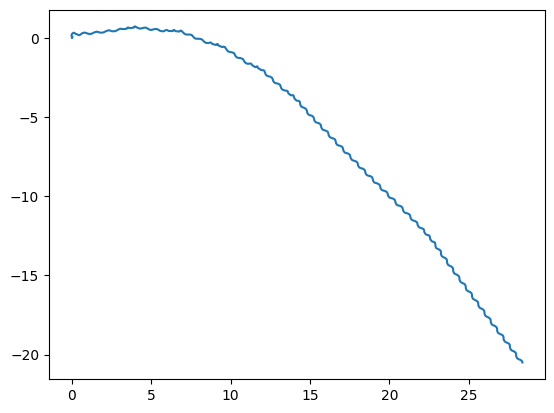

In [211]:
#plot the obs["body_pos"]
body_pos = np.array([obs["body_pos"] for obs in obs_list])
plt.plot(body_pos[:,0], body_pos[:,1])

In [212]:
body_pos = np.array([obs["body_pos"] for obs in obs_list])
start_pt = (body_pos[:,0].astype(int),body_pos[:,1].astype(int))

end_pt = start_pt[1][1] + np.array([-1,3])
print(end_pt)

[-1  3]


In [216]:
cap = cv2.VideoCapture("arista.mp4")
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
fps = cap.get(cv2.CAP_PROP_FPS)

   
size = (frame_width, frame_height)
out = cv2.VideoWriter('arista_wind.avi', cv2.VideoWriter_fourcc(*'MJPG'), fps, size)


In [214]:
while(True): 
      
    # reading from frame 
    ret,frame = cap.read() 
    if ret: 

        cv2.arrowedLine(
            frame,
            (int(frame_width/2), int(frame_height/2)),
            # Need to invert sign of y coordinate as the zero is on top
            (int(frame_width/2)-50, int(frame_height/2)-150),
            color=(0, 0, 255),
            thickness=2,
            tipLength=0.1,
        )

        # save all frames as a video
        out.write(frame)
    else: 
        break

# Release all space and windows once done 
cap.release() 
out.release()
cv2.destroyAllWindows()

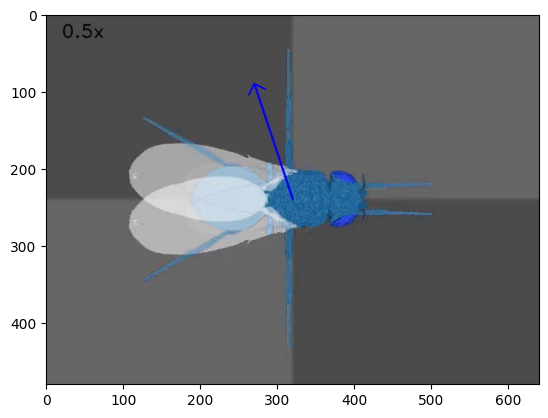

In [217]:
cap = cv2.VideoCapture("arista.mp4")
ret,frame = cap.read() 
cv2.arrowedLine(
            frame,
            (int(frame_width/2), int(frame_height/2)),
            # Need to invert sign of y coordinate as the zero is on top
            (int(frame_width/2)-50, int(frame_height/2)-150),
            color=(0, 0, 255),
            thickness=2,
            tipLength=0.1,
        )
plt.imshow(frame)